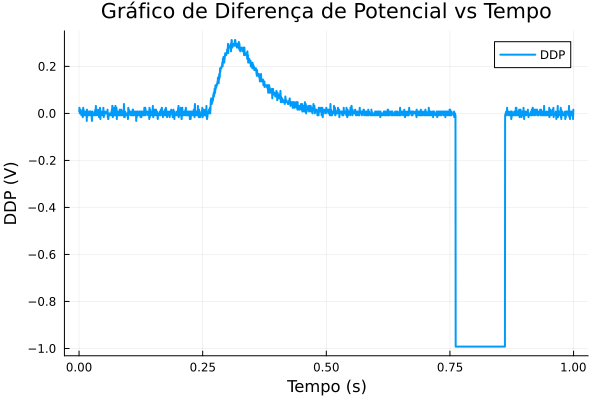

In [76]:
using Plots
using CSV
using DataFrames
using Statistics

dados = CSV.read("dados3/ALL0002/F0002CH1.CSV", DataFrame)

tempo = dados[!, 4]
voltagem = dados[!, 5]

plot(tempo, voltagem, label="DDP", xlabel="Tempo (s)", ylabel="DDP (V)", title="Gráfico de Diferença de Potencial vs Tempo", legend=:topright, grid=true, linewidth=2)

In [77]:
function trapezio(x, y, x0, xN, y_min)
    mask = (x .>= x0) .& (x .<= xN) .& (y .>= y_min)
    if sum(mask) < 3
        return 0.0
    end

    xf = x[mask]
    yf = y[mask]
    dx = xf[2] - xf[1]
    integral = (yf[1] + yf[end]) * dx / 2
    integral += sum(yf[2:end-1]) * dx
    return integral
end

trapezio (generic function with 1 method)

In [78]:
N = 10000  # Número de voltas da bobina
area = 2.5e-3
comprimento = 7.0e-2


function integra_diretorio(diretorio; fator_v=1.0, x0=0, xN=1, y_min=-0.1)
    integrals = Float64[]
    for (root, _, files) in walkdir(diretorio)
        for f in files
            if endswith(f, ".CSV")
                path = joinpath(root, f)
                df   = CSV.read(path, DataFrame)
                t    = df[!, 4] # tempo (já em segundos não precisa converter)
                v    = df[!, 5] .* fator_v # aplica fator de escala

                I = trapezio(t, v, x0, xN, y_min * fator_v)
                push!(integrals, I)
                #println("[$(basename(root))/$(f)]: Integral = $(round(I, digits=5))")
            end
        end
    end
    return integrals
end

# Chamada da função com cada diretório
dados1 = integra_diretorio("dados1"; fator_v=2, x0=0, xN=1, y_min=-1)
dados2 = integra_diretorio("dados2"; fator_v=0.05, x0=0, xN=1, y_min=-0.05)
dados3 = integra_diretorio("dados3"; fator_v=0.2, x0=0, xN=1, y_min=-0.1)

fluxo1 = dados1 / N
fluxo2 = dados2 / N
fluxo3 = dados3 / N

# Cálculo da média e desvio padrão
media1 = mean(fluxo1)
desvio1 = std(fluxo1)
media2 = mean(fluxo2)
desvio2 = std(fluxo2)
media3 = mean(fluxo3)
desvio3 = std(fluxo3)

# Exibição dos resultados
println("Média e Desvio Padrão dos Dados:")
println("Fluxo 1: Média = $(media1), Desvio Padrão = $(desvio1)")
println("Fluxo 2: Média = $(media2), Desvio Padrão = $(desvio2)")
println("fluxo 3: Média = $(media3), Desvio Padrão = $(desvio3)")

# Permeabilidade relativa
mu_r = media3 / media2
println("Permeabilidade Relativa (mu_r) = $(mu_r)")

# Permeabilidade
mu_0 = 4 * pi * 1e-7
mu = mu_r * mu_0
println("Permeabilidade do Material (mu) = $(mu) T·m/A")

Média e Desvio Padrão dos Dados:
Fluxo 1: Média = 9.577874285714288e-5, Desvio Padrão = 3.888470644873105e-7
Fluxo 2: Média = 2.7103166666666646e-8, Desvio Padrão = 9.338372286950961e-10
fluxo 3: Média = 5.604750769230774e-7, Desvio Padrão = 1.651138937451705e-8
Permeabilidade Relativa (mu_r) = 20.67932075303911
Permeabilidade do Material (mu) = 2.598640086358985e-5 T·m/A


In [79]:
# Incertezas
fluxo1_err = desvio1 / sqrt(length(fluxo1))
fluxo2_err = desvio2 / sqrt(length(fluxo2))
fluxo3_err = desvio3 / sqrt(length(fluxo3))
println("Incertezas:")
println("Fluxo 1: Incerteza = $(fluxo1_err)")
println("Fluxo 2: Incerteza = $(fluxo2_err)")
println("Fluxo 3: Incerteza = $(fluxo3_err)")

# Campo magnético imã
B_0_ima = media1 / area
println("Campo Magnético (B_0_imã) = $(B_0_ima) T")
# Incerteza do campo magnético imã
B_0_ima_err = fluxo1_err / area
println("Incerteza do Campo Magnético (B_0_imã_err) = $(B_0_ima_err) T")

# Campo magnético ar 
B_0 = media2 / area
println("Campo Magnético (B_0) = $(B_0) T")
# Incerteza do campo magnético ar
B_0_err = fluxo2_err / area
println("Incerteza do Campo Magnético (B_0_err) = $(B_0_err) T")

# Campo magnético barra de ferro
B_material = media3 / area
println("Campo Magnético (B) = $(B_material) T")
# Incerteza do campo magnético barra de ferro
B_material_err = fluxo3_err / area
println("Incerteza do Campo Magnético (B_err) = $(B_err) T")



Incertezas:
Fluxo 1: Incerteza = 1.0392374936887917e-7
Fluxo 2: Incerteza = 2.6957558768320397e-10
Fluxo 3: Incerteza = 4.579435462997886e-9
Campo Magnético (B_0_imã) = 0.03831149714285715 T
Incerteza do Campo Magnético (B_0_imã_err) = 4.1569499747551665e-5 T
Campo Magnético (B_0) = 1.0841266666666659e-5 T
Incerteza do Campo Magnético (B_0_err) = 1.0783023507328158e-7 T
Campo Magnético (B) = 0.00022419003076923097 T
Incerteza do Campo Magnético (B_err) = 1.8317741851991542e-6 T


In [80]:
# Mesmo cálculo, mas usando Interpolations e QuadGK
using Interpolations, QuadGK

x0, xN, y_min = 0, 1, -0.1

for (root, _, files) in walkdir("dados3")
    for f in files
        if endswith(f, ".CSV")
            path = joinpath(root, f)
            df   = CSV.read(path, DataFrame)
            t    = df[!, 4]
            v    = df[!, 5]

            itp = LinearInterpolation(t, v; extrapolation_bc=0)

            f_int(x) = (val = itp(x); val >= y_min ? val : 0)
            I, err = quadgk(f_int, x0, xN)

            println("[$(basename(root))/$(f)]: Integral = $(round(I, digits=4)) ± $(round(err, digits=11))")
        end
    end
end

[ALL0000/F0000CH1.CSV]: Integral = 0.0287 ± 4.3e-10
[ALL0001/F0001CH1.CSV]: Integral = 0.0283 ± 4.2e-10
[ALL0002/F0002CH1.CSV]: Integral = 0.0289 ± 4.3e-10
[ALL0003/F0003CH1.CSV]: Integral = 0.0288 ± 4.3e-10
[ALL0004/F0004CH1.CSV]: Integral = 0.0278 ± 4.1e-10
[ALL0005/F0005CH1.CSV]: Integral = 0.027 ± 4.0e-10
[ALL0006/F0006CH1.CSV]: Integral = 0.0273 ± 4.1e-10
[ALL0007/F0007CH1.CSV]: Integral = 0.0276 ± 4.1e-10
[ALL0008/F0008CH1.CSV]: Integral = 0.0276 ± 4.1e-10
[ALL0009/F0009CH1.CSV]: Integral = 0.0275 ± 4.1e-10
[ALL0010/F0010CH1.CSV]: Integral = 0.0276 ± 4.1e-10
[ALL0011/F0011CH1.CSV]: Integral = 0.0273 ± 4.1e-10
[ALL0012/F0012CH1.CSV]: Integral = 0.0299 ± 4.4e-10
